In [2]:
#import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
plt.style.use('seaborn-v0_8-dark-palette')

In [5]:
data=pd.read_csv('ner_datasetreference.csv',encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [6]:
print(data.columns)

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')


In [7]:
#Delete the POS column as we do not need it
if 'POS' in data.columns:
    data.drop('POS',axis='columns',inplace=True)
data.head(15)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O
5,NaN,through,O
6,NaN,London,B-geo
7,NaN,to,O
8,NaN,protest,O
9,NaN,the,O


In [8]:
#NaN values to be filled using Forward Fill method.
data=data.fillna(method='ffill')
data.head(35)

C:\Users\rkent\AppData\Local\Temp\ipykernel_31312\1776599694.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data=data.fillna(method='ffill')


,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [9]:
'''Extracting unique values from the 'Word' column of the DataFrame data. It is using the set() function 
to create a set of unique words and then converting that set back into a list. So, the variable words 
will contain a list of unique words found in the 'Word' column of the DataFrame.'''

words=list(set(data['Word'].values))

'''Adding the string "ENDPAD" to the end of the words list. The term "ENDPAD" is often used in natural 
language processing tasks, such as sequence labeling, to indicate the end of a sequence. It's a common 
practice to have a special token like this in NLP tasks.'''

words.append("ENDPAD")

''' Accessing the last element of the words list, which is now "ENDPAD". By using the index -1, referencing the last element in the list.'''
words[-1]

'ENDPAD'

In [10]:
#Total no. of words
num_words=len(data['Word'])
print("Total number of words",num_words)

Total number of words 1048575


In [11]:
#List of Tags and total no. of Tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: B-eve, B-geo, I-org, I-eve, B-org, I-art, I-geo, B-gpe, B-art, I-nat, I-tim, O, I-gpe, B-tim, B-per, B-nat, I-per
Total Number of tags 17


In [12]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [13]:
#Creating a class which will give the complete sentence with Tags attached with each word
class Get_sentence(object):
  def __init__(self,data):
    self.n_sent=1 #keeps track of the sentences
    self.data=data
    
    '''This lambda function takes a group s (a subset of the input data) and aggregates the 'Word' and 'Tag' 
    columns from that group into a list of tuples.'''
    
    agg_func=lambda s:[(w,t) for w,t in zip(s['Word'].tolist(),s['Tag'].tolist())]
    
    '''This line groups the input data by the 'Sentence #' column and applies the agg_func lambda function 
    to each group. It creates a new DataFrame with the aggregated results, where each row represents a 
    sentence with associated words and tags.'''
    
    self.grouped=self.data.groupby('Sentence #').apply(agg_func)
    
    '''This line converts the grouped data into a list of sentences, where each sentence is represented as a
    list of tuples containing words and tags.'''
    
    self.sentences=[s for s in self.grouped]

In [14]:
getter=Get_sentence(data)
sentence=getter.sentences
print(type(sentence))

<class 'list'>


C:\Users\rkent\AppData\Local\Temp\ipykernel_31312\1398642793.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped=self.data.groupby('Sentence #').apply(agg_func)


In [15]:
#Each sentence is a list of tuples containing words and tags
sentence[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

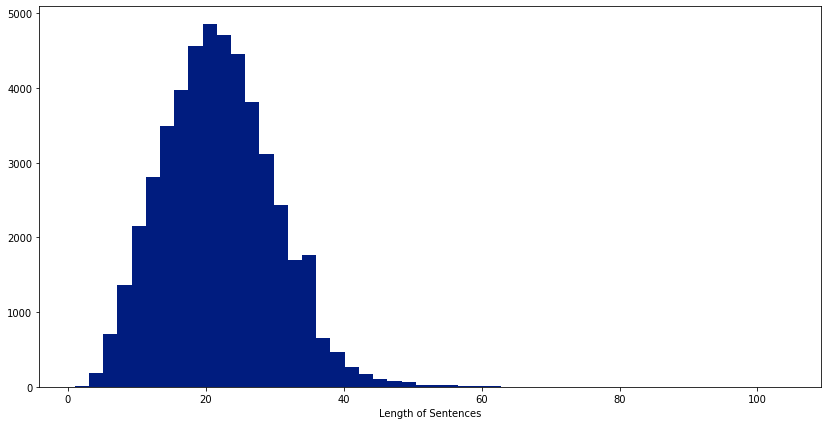

In [16]:
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

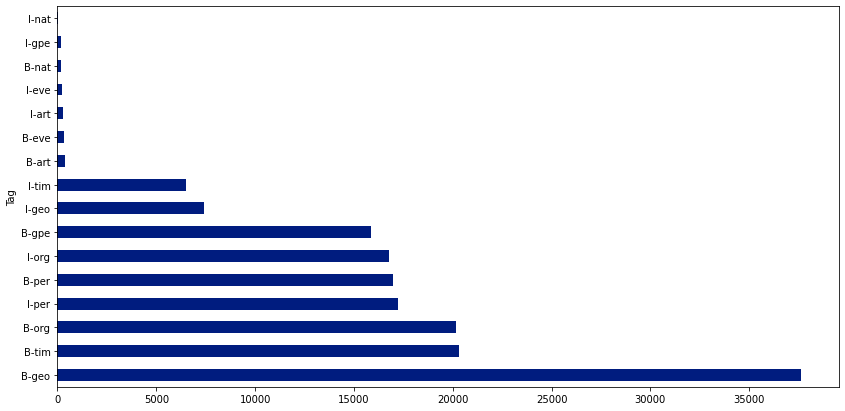

In [17]:
# most of our sentenses have a length of 20 words, the longest sentense is around 63 words
plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

In [18]:
## We can understand from the bar chart above that B-geo Tags are over-represented. 
## I-nat and I-gpe Tags are negligible and almost non-existent. Model will have difficulty in classifying these 2 tags,

In [19]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}
len(tag_idx)

17

In [20]:
word_idx['PAD']=0
# Padding our sentences using max lenght of 50.
max_len=50
padding_value = word_idx['PAD']
X=[[word_idx[w[0]] for w in s] for s in sentence]
X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=padding_value)
y=[[tag_idx[w[1]]for w in s]for s in sentence]
y=pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag_idx['O'])
# 1st sentence's numerical representation mapped with the respective indices
X[0]

array([16816, 16848,  2325, 19829, 15307,  9740, 18600,  2544, 18587,
       35000, 14416,  6443, 27108, 32403, 13267, 35000,  4660, 16848,
       27647, 17038, 19450, 10082, 31529, 12012,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [21]:
# 1st sentence's tag representation, numerically mapped with respective tag indices
y[0]

array([11, 11, 11, 11, 11, 11,  1, 11, 11, 11, 11, 11,  1, 11, 11, 11, 11,
       11,  7, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [22]:
y=[to_categorical(i,num_classes=num_tags) for i in y]
num_tags

17

In [23]:
y[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0

In [24]:
# Split the data using Train Test split.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=1)

In [25]:
'''This line creates an input layer for the neural network with a shape of (max_len,), 
where max_len represents the maximum length of the input sequences (sentences).'''

input_word=Input(shape=(max_len,))

'''This line adds an embedding layer to the model. It converts the input word indices into dense 
vectors of a specified output_dim dimension. input_dim represents the total number of unique words in the 
vocabulary, and input_length specifies the length of each input sequence.'''

model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)

'''This line adds a 1D spatial dropout layer to the model. Spatial dropout drops entire 1D feature maps 
instead of individual elements, which helps to regularize the network by preventing overfitting. 
The dropout rate is set to 0.1, which means 10% of the features will be dropped during training.'''

model=SpatialDropout1D(0.1)(model)

'''Here, a Bidirectional LSTM layer is added. This layer allows the model to learn from both the past and 
future context of the input sequence. The units parameter sets the number of LSTM units/neurons in each 
direction, and return_sequences=True ensures that the output of this layer is a sequence 
(important for sequence labeling tasks). recurrent_dropout introduces dropout in the recurrent 
connections to prevent overfitting.'''

model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)

'''TimeDistributed wrapper is applied to a Dense layer, which produces an output for each time step of 
the sequence. This is necessary for sequence labeling tasks. The Dense layer's output size is num_tags, 
representing the number of unique tag classes, and the activation function is softmax, which is common 
for multi-class classification problems.'''

out=TimeDistributed(Dense(num_tags,activation='softmax'))(model)


model=Model(input_word,out)

'''The model is compiled with the Adam optimizer, categorical cross-entropy loss 
(suitable for multi-class classification), and accuracy as the evaluation metric.'''

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

D:\Applications\Python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 50)              │      52,428,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 200)             │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 17)              │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,552,967 (200.47 MB)

 Trainable params: 52,552,967 (200.47 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
plot_model(model,show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [27]:
#Training the model with Training data
model.fit(X_train,np.array(y_train),batch_size=64,verbose=1,epochs=3,validation_split=0.2)

Epoch 1/3
540/540 ━━━━━━━━━━━━━━━━━━━━ 361s 644ms/step - accuracy: 0.9278 - loss: 0.4150 - val_accuracy: 0.9758 - val_loss: 0.0869
Epoch 2/3
540/540 ━━━━━━━━━━━━━━━━━━━━ 340s 630ms/step - accuracy: 0.9798 - loss: 0.0721 - val_accuracy: 0.9835 - val_loss: 0.0555
Epoch 3/3
540/540 ━━━━━━━━━━━━━━━━━━━━ 337s 625ms/step - accuracy: 0.9867 - loss: 0.0456 - val_accuracy: 0.9850 - val_loss: 0.0490


In [28]:
model.evaluate(X_test,np.array(y_test))

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9847 - loss: 0.0519


[0.05050758272409439, 0.9850375652313232]

In [29]:
rand_sent=np.random.randint(0,X_test.shape[0])
print('randam sentence',rand_sent)
p=model.predict(np.array([X_test[rand_sent]]))
#print('prediction:',p)
p=np.argmax(p,axis=-1)
print(p[0])

y_true=np.argmax(np.array(y_test),axis=-1)[rand_sent]

print("{:20}{:20}\t{}\n".format("Word","True","Pred"))
print("-"*55)

for (w,t,pred)in zip(X_test[rand_sent],y_true,p[0]):
    print("{:20}{:20}\t{}".format(words[w-1],tags[t],tags[pred]))

randam sentence 2499
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 13 10 11 11 11  6 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11]
Word                True                	Pred

-------------------------------------------------------
Police              O                   	O
say                 O                   	O
they                O                   	O
recovered           O                   	O
weapons             O                   	O
and                 O                   	O
ammunition          O                   	O
when                O                   	O
they                O                   	O
captured            O                   	O
the                 O                   	O
men                 O                   	O
during              O                   	O
a                   O                   	O
raid                O                   	O
Tuesday             B-tim               	